In [1]:
%matplotlib inline

import json
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors, patches
import ants
import nibabel as nib
import os, urllib, zipfile
from sklearn.model_selection import train_test_split
from tqdm import tqdm

print(f'AntsPy version = {ants.__version__}')
#print(f'SimpleITK version = {sitk.__version__}')

AntsPy version = 0.5.3


# Download Dataset

In [2]:
# download dataset
filename = 'AbdomenCTCT.zip'
if not os.path.exists(filename):
    url = 'https://cloud.imi.uni-luebeck.de/s/32WaSRaTnFk2JeT/download/AbdomenCTCT.zip'
    urllib.request.urlretrieve(url, filename)

    # extract files
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('./')

In [3]:
def load_data(jsonData, dataFolderPath, training_or_test, filterString='0001'):
    images = []
    labels = []
    for sample in jsonData[training_or_test]:
        image = nib.load(dataFolderPath + sample['image'].removeprefix('.').replace(".csv", ".nii.gz")).get_fdata()
        images.append(image)
        if training_or_test == 'training':
            label = nib.load(dataFolderPath + sample['label'].removeprefix('.').replace(".csv", ".nii.gz")).get_fdata()
            labels.append(label)

    return np.array(images), np.array(labels)

In [4]:
# load data
with open('./AbdomenCTCT/AbdomenCTCT_dataset.json', 'r') as file:
    data_json = json.load(file)
dataFolder = './AbdomenCTCT'
images_raw, labels_raw = load_data(data_json, dataFolder, 'training')

In [5]:
images_raw.shape

(30, 192, 160, 256)

In [6]:
labels_raw.shape

(30, 192, 160, 256)

In [7]:
np.min(images_raw)

-1024.0

In [8]:
np.max(images_raw)

3071.000732421875

# Preprocess data

In [9]:
# normalize images
images_normalized = (images_raw - np.min(images_raw)) / (np.max(images_raw) - np.min(images_raw))

# rotate tensor
images_rotated = np.array([np.rot90(image, k=1, axes=(0, 2)) for image in images_normalized])
labels_rotated = np.array([np.rot90(image, k=1, axes=(0, 2)) for image in labels_raw])

# swap and flip axes
images = np.swapaxes(images_rotated, 1, 2)[:, ::-1, :, :]
labels = np.swapaxes(labels_rotated, 1, 2)[:, ::-1, :, :]

# prepare tensor just with organs
organs = np.zeros_like(images)
organs[labels > 0] = images[labels > 0]

(-0.5, 191.5, 255.5, -0.5)

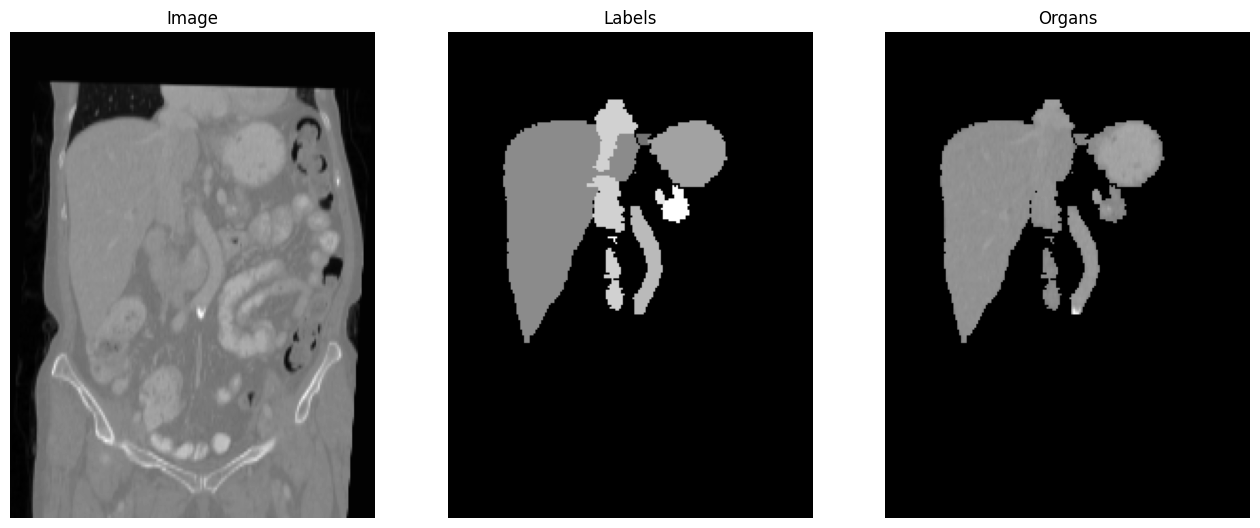

In [10]:
# preview data
img = 0
depth = 70

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(16, 8))
ax0.imshow(images[img, depth], cmap='gray')
ax0.set_title("Image")
ax0.axis("off")
ax1.imshow(labels[img, depth], cmap='gray')
ax1.set_title("Labels")
ax1.axis("off")
ax2.imshow(organs[img, depth], cmap='gray')
ax2.set_title("Organs")
ax2.axis("off")

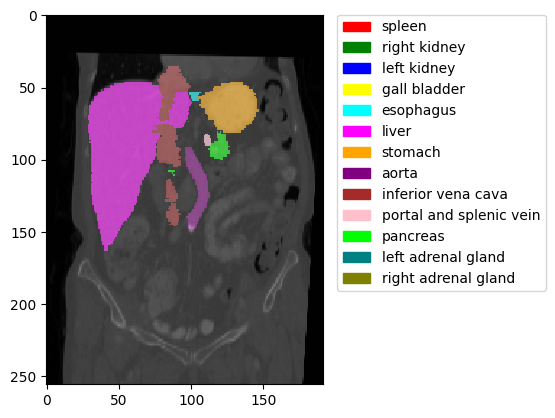

In [11]:
# setup colormap
cmap = colors.ListedColormap([
    'black', 'red', 'green', 'blue', 'yellow', 'cyan', 'magenta', 'orange',
    'purple', 'brown', 'pink', 'lime', 'teal', 'olive'
])
norm = colors.BoundaryNorm(boundaries=np.arange(-0.5, 14, 1), ncolors=14)

# view image
plt.imshow(images[img, depth], cmap='gray', interpolation='none')

# view colors
plt.imshow(labels[img, depth], cmap=cmap, norm=norm, alpha=0.5, interpolation='none')

# setup legend
legend_labels = {
    1: "spleen",
    2: "right kidney",
    3: "left kidney",
    4: "gall bladder",
    5: "esophagus",
    6: "liver",
    7: "stomach",
    8: "aorta",
    9: "inferior vena cava",
    10: "portal and splenic vein",
    11: "pancreas",
    12: "left adrenal gland",
    13: "right adrenal gland"
}

# view rectangles in legend
patches_list = [
    patches.Patch(color=cmap(i), label=legend_labels[i])
    for i in range(1, 14)
]

# view legend
plt.legend(handles=patches_list, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

In [ ]:
del images_raw, labels_raw, images_rotated, labels_rotated

In [12]:
# split dataset
training_organs, test_organs = train_test_split(organs, test_size=0.2, random_state=10)

In [13]:
training_organs.shape

(24, 160, 256, 192)

In [14]:
test_organs.shape

(6, 160, 256, 192)

In [ ]:
del training_organs, images, organs, labels

# Ants Registration Vsiualisation

In [15]:
# Load your fixed and moving images
fixed_image = ants.from_numpy(test_organs[img + 3])
moving_image = ants.from_numpy(test_organs[img])

In [16]:
registration = ants.registration(
    fixed=fixed_image,
    moving=moving_image,
    type_of_transform='SyNRA',
    aff_metric='mattes',
    aff_sampling=32,
    verbose=True
)

antsRegistration -d 3 -r [000001EA481EEF08,000001EA481EFF68,1] -m mattes[000001EA481EEF08,000001EA481EFF68,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x0 -s 3x2x1x0 -f 4x2x2x1 -x [NA,NA] -m mattes[000001EA481EEF08,000001EA481EFF68,1,32,regular,0.2] -t Affine[0.25] -c 2100x1200x1200x0 -s 3x2x1x0 -f 4x2x2x1 -x [NA,NA] -m mattes[000001EA481EEF08,000001EA481EFF68,1,32] -t SyN[0.200000,3.000000,0.000000] -c [40x20x0,1e-7,8] -s 2x1x0 -f 4x2x1 -u 1 -z 1 -o [C:\Users\Tilmann\AppData\Local\Temp\tmp5wh5fovp,000001EA481EF2C8,000001EA481EEDE8] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1


In [17]:
print(registration)

{'warpedmovout': ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (160, 256, 192)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
, 'warpedfixout': ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (160, 256, 192)
	 Spacing    : (1.0, 1.0, 1.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]
, 'fwdtransforms': ['C:\\Users\\Tilmann\\AppData\\Local\\Temp\\tmp5wh5fovp1Warp.nii.gz', 'C:\\Users\\Tilmann\\AppData\\Local\\Temp\\tmp5wh5fovp0GenericAffine.mat'], 'invtransforms': ['C:\\Users\\Tilmann\\AppData\\Local\\Temp\\tmp5wh5fovp0GenericAffine.mat', 'C:\\Users\\Tilmann\\AppData\\Local\\Temp\\tmp5wh5fovp1InverseWarp.nii.gz']}


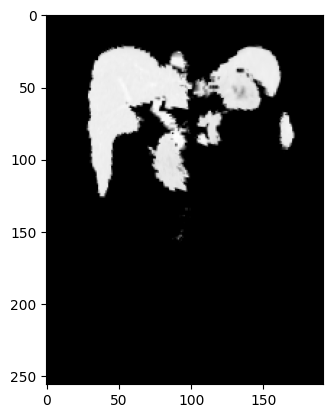

In [18]:
registered_img_ants = registration['warpedmovout']
plt.imshow(registered_img_ants.numpy()[depth], cmap='gray')

(-0.5, 191.5, 255.5, -0.5)

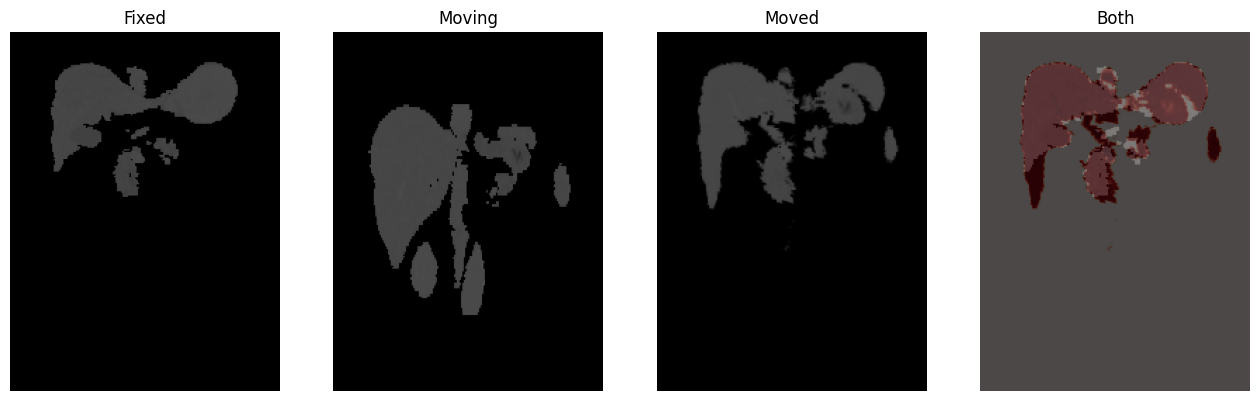

In [19]:
# preview data

fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(16, 8))
ax0.imshow(test_organs[img + 3][depth], cmap='gray', vmin=0, vmax=1)
ax0.set_title("Fixed")
ax0.axis("off")
ax1.imshow(test_organs[img][depth], cmap='gray', vmin=0, vmax=1)
ax1.set_title("Moving")
ax1.axis("off")
ax2.imshow(registered_img_ants.numpy()[depth], cmap='gray', vmin=0, vmax=1)
ax2.set_title("Moved")
ax2.axis("off")
ax3.imshow(test_organs[img + 3][depth], cmap='gray', vmin=0, vmax=1)
ax3.imshow(registered_img_ants.numpy()[depth], alpha=0.3, cmap='Reds')
ax3.set_title("Both")
ax3.axis("off")

In [20]:
# Access the transformation matrix or deformation field
transformation = registration['fwdtransforms'][0]  # Forward transformation

In [21]:
# Apply the transformation to the moving image
warped_image = ants.apply_transforms(fixed=fixed_image, moving=moving_image, transformlist=transformation)


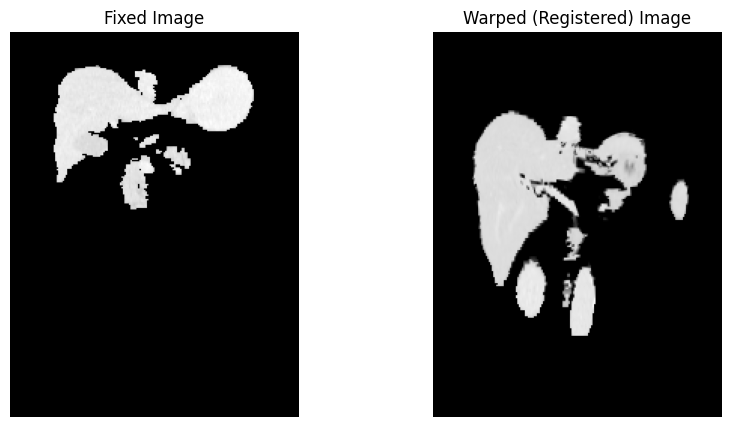

In [22]:
# Convert images to numpy arrays for visualization
fixed_np = fixed_image.numpy()
warped_np = warped_image.numpy()

# Display fixed and warped images side by side for comparison
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(fixed_np[depth], cmap='gray')
axes[0].set_title('Fixed Image')
axes[0].axis('off')

axes[1].imshow(warped_np[depth], cmap='gray')
axes[1].set_title('Warped (Registered) Image')
axes[1].axis('off')

plt.show()


In [23]:
# Load the displacement field (transformation field)
displacement_field = ants.image_read(transformation)


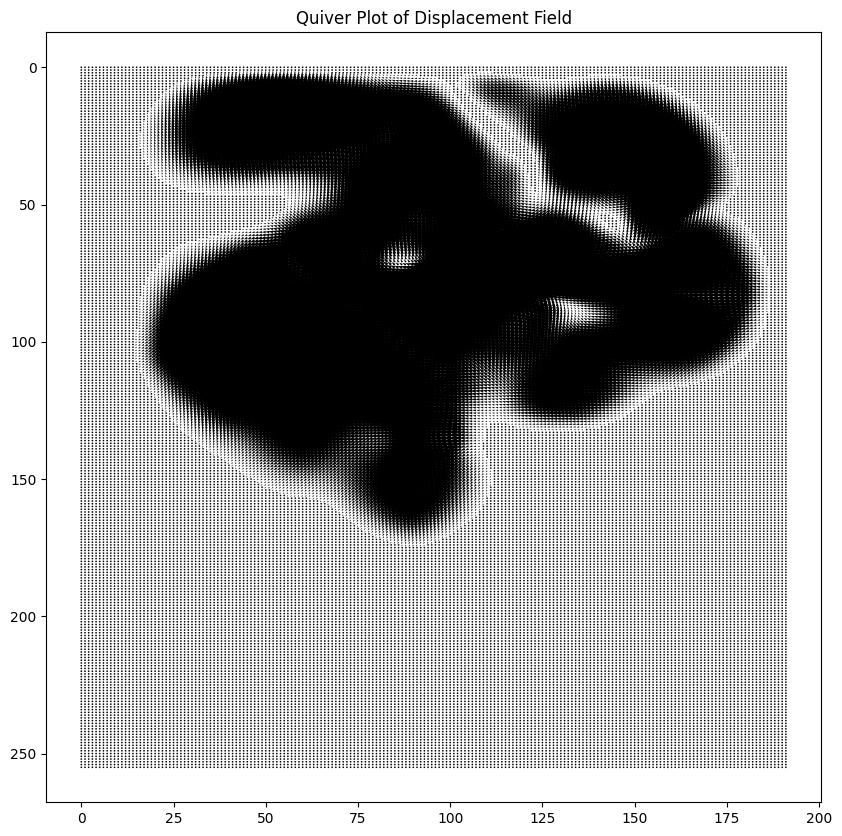

In [24]:
# Assume the displacement field is 3D with 3 components
displacement_field_np = displacement_field.numpy()

# Extract a 2D slice (e.g., middle slice)
x_displacement = displacement_field_np[depth, :, :, 0]
y_displacement = displacement_field_np[depth, :, :, 1]

# Generate a grid of coordinates
x, y = np.meshgrid(np.arange(x_displacement.shape[1]), np.arange(x_displacement.shape[0]))

# Create a quiver plot
plt.figure(figsize=(10, 10))
plt.quiver(x, y, x_displacement, y_displacement, scale=1, scale_units='xy', angles='xy')
plt.title("Quiver Plot of Displacement Field")
plt.gca().invert_yaxis()  # To match image coordinate system
plt.show()

# Evaluation

In [25]:
def dice_score_np(y_true, y_pred, smooth=1e-6):
    # Convert the input arrays to binary format
    binary_y_true = (y_true > 0).astype(np.float32)
    binary_y_pred = (y_pred > 0).astype(np.float32)

    # Flatten the arrays
    y_true_flat = binary_y_true.flatten()
    y_pred_flat = binary_y_pred.flatten()

    # Calculate the intersection and union
    intersection = np.sum(y_true_flat * y_pred_flat)
    union = np.sum(y_true_flat) + np.sum(y_pred_flat)

    # Calculate the Dice coefficient
    dice = (2. * intersection + smooth) / (union + smooth)

    return float(dice)



In [26]:
n = test_organs.shape[0]
count = 0
dice = 0
mse = 0
for i in tqdm(range(n)):
    for j in range(n):
        if i == j:
            continue
        else:
            count += 1
            fix_img = ants.from_numpy(test_organs[i])
            mov_img = ants.from_numpy(test_organs[j])
            reg = ants.registration(
                fixed=fix_img,
                moving=mov_img,
                type_of_transform='SyNRA',
                aff_metric='mattes',
                aff_sampling=32,
            )
            
            reg_img = reg['warpedmovout']
            
            dice += dice_score_np(fix_img.numpy(), reg_img.numpy())
            mse += np.mean(np.square(fix_img.numpy() - reg_img.numpy()))

100%|██████████| 6/6 [36:00<00:00, 360.02s/it]


In [27]:
print("Dice: " + str(dice / count))
print("MSE: " + str(mse / count))

Dice: 0.8317187859305288
MSE: 0.0011546109395567327
